In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm


from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap


plt.style.use(['science', 'grid', 'notebook'])

# Ejercicio 2 - Problema de la paridad

Generación de entradas-salidas

In [2]:
NI=5    # para que ande NI impar
x=[]
for i in range(2**NI):
    num=bin(i)[2:]                            # covierte decimal a binario
    a=np.array([int(z) for z in str(num)])    # pone los numeros en un vector
    while len(a)<NI:                          # llena con ceros si es necesario
        a=np.insert(a,0,0)
    x.append(a)
x=np.array(x)
y=np.zeros(2**NI)
for i in range(2**NI):      # calculo salidas
    y[i]=sum(x[i,:])%2

x[x==0]=-1                  # opcional: representacion -1,1
y[y==0]=-1                  # opcional: representacion -1,1

# testeo generacion
for i in range(2**NI):
    if np.prod(x[i]) != y[i]:
        print('Fallo')
        break

print(x.shape, y.shape)

(32, 5) (32,)


Definición de la red

In [3]:
activation = lambda h: np.tanh(h)
derivate_act = lambda h: 1 - np.tanh(h)**2

def begin(NI, NH, No, seed = 42):  # prepara los coeficientes de la red
    # Semilla aleatoria para reproducibilidad
    np.random.seed(seed)

    # red totalmente conectada con NI entrdas, NH capas ocultas y NO salidas
    # weights
    w_ih = np.random.rand(NI, NH)
    w_ho = np.random.rand(NH, No)
    #bias
    b0 = np.random.rand(NH)
    b1 = np.random.rand(No)

    return (w_ih, w_ho, b0, b1)
    

#Definicion de la red
def NN(x, w_ih, w_ho, b0, b1):
    Vj = activation(np.dot(x, w_ih) + b0)
    oi = activation(np.dot(Vj, w_ho) + b1)

    return oi

# train sin batch
# def train(epochs, lr, w_ih, w_ho, b0, b1, act, grad_act, epsilon=0.01):
#     accuracies = np.zeros(epochs)
#     mse = np.zeros(epochs)

#     for i in range(epochs):

#         grad_w_0_1 = np.zeros_like(w_ih)
#         grad_w_1_2 = np.zeros_like(w_ho)
#         grad_b0 = np.zeros_like(b0)
#         grad_b1 = np.zeros_like(b1)

#         for mu in range(x.shape[0]):    # itero en todos los ejemplos de la red
#             # Forward projection
#             # input -> hidden
#             hj = np.dot(x[mu], w_ih) + b0
#             Vj = act(hj)
#             # hidden ->output
#             hi = np.dot(Vj, w_ho) + b1
#             oi = act(hi)

#             # Backprojection
#             #ouput -> hiiden
#             delta_i_mu = grad_act(hi) * (y[mu] - oi)
#             grad_w_1_2 += np.outer(Vj, delta_i_mu)
#             grad_b1 += delta_i_mu

#             # hidden -> input
#             delta_j_mu = grad_act(hj) * np.dot(delta_i_mu, w_ho.T)
#             grad_w_0_1 += np.outer(x[mu], delta_j_mu)
#             grad_b0 += delta_j_mu

#             # metricas
#             accuracies[i] += 1 if (np.abs(oi[0] - y[mu]) < epsilon) else 0
#             mse[i] += (oi[0] - y[mu])**2

        
#         # actualizo los pesos
#         w_ih += lr * grad_w_0_1
#         w_ho += lr * grad_w_1_2
#         b0 += lr * grad_b0
#         b1 += lr * grad_b1

#     # armo diccionario de metricas
#     metrics = {'accuracy': accuracies/len(y), 'mse': mse/len(y)}

#     return w_ih, w_ho, b0, b1, metrics



def train(epochs, x_train, y_train, lr, w_ih, w_ho, b0, b1, act, grad_act, batch_size=32, epsilon=0.01):
    accuracies = np.zeros(epochs)
    mse = np.zeros(epochs)

    num_samples = x_train.shape[0]

    for i in range(epochs):
        grad_w_0_1 = np.zeros_like(w_ih)
        grad_w_1_2 = np.zeros_like(w_ho)
        grad_b0 = np.zeros_like(b0)
        grad_b1 = np.zeros_like(b1)

        # Divido el conjunto de datos en mini-batches
        indices = np.random.permutation(num_samples)  # Barajo los datos
        x_shuffled = x_train[indices]
        y_shuffled = y_train[indices]

        for start in range(0, num_samples, batch_size):
            # Seleccionar el batch
            end = min(start + batch_size, num_samples)
            x_batch = x_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward projection (vectorizado)
            hj = np.dot(x_batch, w_ih) + b0  # (batch_size, NH)
            Vj = act(hj)  # Activación de la capa oculta
            hi = np.dot(Vj, w_ho) + b1  # (batch_size, No)
            oi = act(hi)  # Salida de la red

            # Backprojection (vectorizado)
            # Calculo de gradientes de salida (output -> hidden)
            delta_i_mu = grad_act(hi) * (y_batch[:, np.newaxis] - oi)  # (batch_size, No)
            grad_w_1_2 += np.dot(Vj.T, delta_i_mu)  # (NH, No)
            grad_b1 += np.sum(delta_i_mu, axis=0)  # (No,)

            # Calculo de gradientes de la capa oculta (hidden -> input)
            delta_j_mu = grad_act(hj) * np.dot(delta_i_mu, w_ho.T)  # (batch_size, NH)
            grad_w_0_1 += np.dot(x_batch.T, delta_j_mu)  # (NI, NH)
            grad_b0 += np.sum(delta_j_mu, axis=0)  # (NH,)

            # Métricas
            accuracies[i] += np.sum(np.abs(oi.flatten() - y_batch) < epsilon)  # Accuracy
            mse[i] += np.sum((oi.flatten() - y_batch) ** 2)  # MSE

        # Actualizo los pesos
        w_ih += lr * grad_w_0_1
        w_ho += lr * grad_w_1_2
        b0 += lr * grad_b0
        b1 += lr * grad_b1

    metrics = {'accuracy': accuracies / len(y_train), 'mse': mse / len(y_train)}

    return w_ih, w_ho, b0, b1, metrics


Métricas

In [4]:

def accuracy(y_pred, y_true, epsilon=0.01):
    """accuracy

    Mide la proporción de predicciones correctas sobre el total de predicciones

    Args:
        y_pred (array): predicción de la red
        y_true (array): salida real
        epsilon (float, optional): tolerancia para salidas continuas. Defaults to 0.01.

    Returns:
        float: valor de accuracy
    """
    # Contar cuántas predicciones están dentro del umbral
    predicciones_correctas = np.sum(np.abs(y_pred - y_true) < epsilon)
    
    # Calcular el accuracy
    accuracy = predicciones_correctas / len(y_true)
    
    return accuracy
def MSE(y_pred, y_true):
    """MSE: Mean Squared error

    Args:
        y_pred (array): predicción de la red
        y_true (array): salida real

    Returns:
        float: valor de MSE
    """
    return np.mean((y_pred - y_true) ** 2)


In [4]:
epochs = 40000

NH = np.array([1, 3, 5, 7, 9, 11])  # es el que luego vamos a variar
No = 1
learning_rate = 0.1

accuracies = np.empty((len(NH), epochs))
mses = np.empty((len(NH), epochs))

for i, nh in enumerate(tqdm.tqdm(NH, desc='Trainning')):
    # BEGIN
    weights = begin(NI, nh, No)
    #TRAIN
    _, _, _, _, metrics = train(epochs, x, y, learning_rate, *weights, activation, derivate_act, batch_size=4, epsilon=0.1)
    
    accuracies[i] = metrics['accuracy']
    mses[i] = metrics['mse']

Trainning: 100%|██████████| 6/6 [00:46<00:00,  7.82s/it]


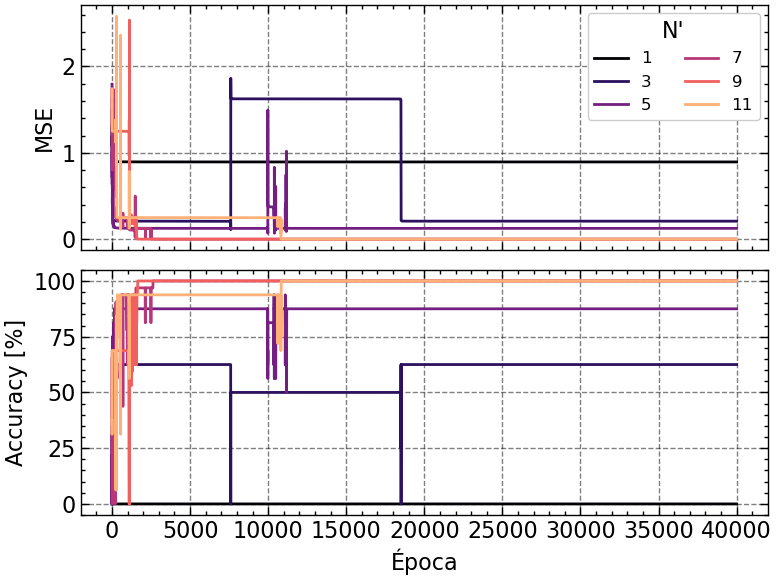

In [11]:
epoch_axis = np.arange(epochs)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# cm =truncate_colormap(plt.get_cmap('pink'), 0, 0.7)
cm = plt.get_cmap('magma')
# cm = plt.get_cmap('magma')

for i in range(len(NH)):
    ax[1].plot(epoch_axis, accuracies[i]*100, label=f'{NH[i]}', color=cm(i/len(NH)), lw=2)
    ax[0].plot(epoch_axis, mses[i], color=cm(i/len(NH)), lw=2, label=f'{NH[i]}')


ax[1].set_ylabel('Accuracy [%]')
ax[1].set_xlabel('Época')
ax[0].set_ylabel('MSE')
ax[0].legend(fontsize=12, title="N'", ncols=2)

plt.tight_layout()

plt.savefig('../doc/figures/metrics_e2.pdf')